# Caffe2 Basic Elements
In this tutorial, we will go through a set of basic elements for Caffe2.

In [1]:
from matplotlib import pyplot
import numpy as np
import time

from caffe2.python import core, workspace
from caffe2.proto import caffe2_pb2

%matplotlib inline


## Workspace
First we will look into the workspace, where all the data reside. Workspace consists of all the blobs and data you created and stored in memory.

One can feed blobs in the workspace using `FeedBlob()`

In [2]:
X = np.random.randn(2,2).astype(np.float32)
print("Numpy random array X:\n{}".format(X))
workspace.FeedBlob("X", X)

Numpy random array X:
[[ 0.3728585  -0.38201433]
 [ 1.7013371  -0.3140982 ]]


True

`Blobs()` can be used to print out all existing blobs in the workspace.

## Operators

Operators in Caffe2 are to define the functions like operations. "Create an operator" in Caffe2 python would only define the computational graph, At later time it would be executed in the C++ backend.

One example is to define a computational graph Relu.

In [3]:
op = core.CreateOperator(
    "Relu", #The type of operator that we want to run
    ["X"],  #A list of input blobs
    ["Y"]   #A list of output blobs
)

We can feed the input X to the workspace through `workspace.RunOperatorOnce(operator)`

In [4]:
workspace.FeedBlob("X", np.random.randn(2, 2).astype(np.float32))
workspace.RunOperatorOnce(op)

True

Here we check if the operator is excuted and what would be the results on X, Y, and the expected value of Y.

In [5]:
print("Current blobs in the workspace: {}\n".format(workspace.Blobs()))
print("X:\n{}\n".format(workspace.FetchBlob("X")))
print("Y:\n{}\n".format(workspace.FetchBlob("Y")))
print("Expected:\n{}\n".format(np.maximum(workspace.FetchBlob("X"), 0)))

Current blobs in the workspace: [u'X', u'Y']

X:
[[-1.9222305  -0.26815236]
 [ 0.3026588   1.6451247 ]]

Y:
[[0.        0.       ]
 [0.3026588 1.6451247]]

Expected:
[[0.        0.       ]
 [0.3026588 1.6451247]]



Operators can also take optional arguments, which are specified as key-value pairs. One example is to feed a tensor and fills it with Gaussian random variables with zero mean and 1 standard deviation.

In [10]:
op=core.CreateOperator(
    'GaussianFill',
    [],
    ["Z"],
    shape=[100,100],
    mean=0.0,
    std=1.0,
)
print ("Content of op:\n")
print (str(op))

Content of op:

output: "Z"
name: ""
type: "GaussianFill"
arg {
  name: "std"
  f: 1.0
}
arg {
  name: "shape"
  ints: 100
  ints: 100
}
arg {
  name: "mean"
  f: 0.0
}



We can then feed data to the op through `workspace.RunOperatorOnce(op)`.

Text(0.5,1,u'Distribution of Z')

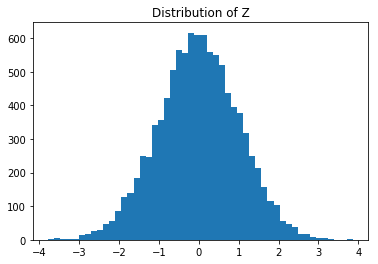

In [11]:
workspace.RunOperatorOnce(op)
temp = workspace.FetchBlob("Z")
pyplot.hist(temp.flatten(),bins=50)
pyplot.title("Distribution of Z")

## Nets

Nets are computational graphs. A Net is composed of multiple operators.

We can create a computational graph like we presented in the beginning of the section.
```
X = np.random.randn(2,3)
W = np.random.randn(5,3)
b = np.ones(5)
Y = X * W^T + b
```

In [5]:
net = core.Net("first computational graph")
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "first computational graph"



In [6]:
X = net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
print("New network proto:\n\n{}".format(net.Proto()))

New network proto:

name: "first computational graph"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}



In [7]:
print("Type of X is: {}".format(type(X)))
print("The blob name is: {}".format(str(X)))

Type of X is: <class 'caffe2.python.core.BlobReference'>
The blob name is: X


In [8]:
W = net.GaussianFill([], ["W"], mean=0.0, std=1.0, shape=[5, 3], run_once=0)
b = net.ConstantFill([], ["b"], shape=[5,], value=1.0, run_once=0)
Y = X.FC([W, b], ["Y"])

In [9]:
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "first computational graph"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



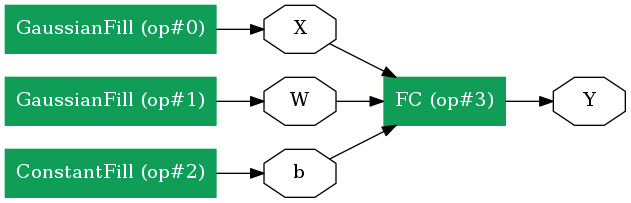

In [10]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(net, rankdir="LR")
display.Image(graph.create_png(), width=800)

There are two ways to run a Net in Caffe2 Python. 

1. Using `workspace.RunNetOnce()` to run and immediately destructs the network. This is slow but simple.
2. a) Call `workspace.CreateNet()` to create a C++ net object owned by the workspace; and then b) use `workspace.RunNet()` by passing the name of the network to it. This method is fast but a bit more complicated.

In [11]:
# First way to use workspace.RunNetOnce() to run a Net
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.RunNetOnce(net)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
# Let's dump the contents of the blobs
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.57749766  0.6867224  -1.9023067 ]
 [-0.10988712 -1.8403648   0.37995943]
 [ 0.36243936 -0.12583214 -0.22221568]
 [ 0.73073703  1.7471557   1.6222508 ]
 [-1.3405846   0.8067382  -2.036345  ]]
X:
[[-1.2473389  -0.71878403 -0.67345744]
 [-0.41355348  0.66690105  0.0844199 ]]
Y:
[[ 2.5078528   2.2040048   0.78801423 -2.2598212   3.4636846 ]
 [ 1.5362096  -0.1498208   0.747435    1.9999313   1.9205099 ]]
b:
[1. 1. 1. 1. 1.]


In [12]:
#a) Call `workspace.CreateNet()` to create a C++ net object owned by the workspace; 
#and then b) use `workspace.RunNet()` by passing the name of the network to it.
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.CreateNet(net)
workspace.RunNet(net.Proto().name)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.785413   -0.6661649   0.08374718]
 [-0.42967272  0.841478   -0.33365878]
 [-1.4906715  -0.8878296   2.0791721 ]
 [-0.9133536  -0.3068954   0.21087232]
 [ 0.5454768   1.6547596   1.1038861 ]]
X:
[[-0.06542487  1.1953484   0.40998346]
 [-0.07352213  1.3930234  -0.5240351 ]]
Y:
[[ 0.28942138  1.8971761   0.8886875   0.7793633   3.3949015 ]
 [ 0.08587551  2.3786378  -1.2167292   0.52913475  2.6865392 ]]
b:
[1. 1. 1. 1. 1.]


In [13]:
start = time.time()
for i in range(1000):
    workspace.RunNetOnce(net)
end = time.time()
print('Run time per RunNetOnce: {}'.format((end - start) / 1000))

start = time.time()
for i in range(1000):
    workspace.RunNet(net.Proto().name)
end = time.time()
print('Run time per RunNet: {}'.format((end - start) / 1000))

Run time per RunNetOnce: 9.42590236664e-05
Run time per RunNet: 7.55906105042e-06


Note: this tutorial is created based on the `https://github.com/caffe2/caffe2/tree/master/caffe2/python/tutorials`. For more detailed explaination, please find more information from `https://caffe2.ai/docs/`. 